In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
import keras
import pandas as pd
from keras.layers import GRU
import tensorflow as tf

2023-05-03 10:25:25.965483: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-03 10:25:26.512189: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
# 데이터 불러오기
data = pd.read_csv('/home/siwon/dev/Deeplearning-6/data/data_carla/carla_data.csv')
data = data.iloc[:, :4]  # 데이터의 첫 4개 열만 사용

# 입력 데이터와 타겟 데이터로 나누기
input_data = []
target_data = []

# 각 id 그룹에 대해 반복
for group_id in data['id'].unique():
    group_data = data[data['id'] == group_id].reset_index(drop=False)
    num_samples = len(group_data)  # group_datat : 각 id에 대하는 좌표들의 갯수

    # 각 그룹 내에서 10개의 연속된 데이터를 입력으로, 그 다음 데이터의 좌표를 타겟으로 사용
    for i in range(10, num_samples):
        input_data.append(group_data.iloc[i-10:i][['X', 'Y','point_id']].to_numpy())
        target_data.append(group_data.iloc[i][['X', 'Y','point_id']].to_numpy())

# numpy 배열로 변환
input_data = np.array(input_data)
target_data = np.array(target_data)

# 학습용과 검증용으로 데이터를 나눔
train_input, test_input, train_target, test_target = train_test_split(input_data, target_data, test_size=0.2, random_state=42)


In [5]:
# LSTM 모델 만들기
model = Sequential()
model.add(LSTM(32, input_shape=(10, 3), return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(3))

# 모델 컴파일
model.compile(loss='mse', optimizer='adam')

# EarlyStopping 콜백 설정
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# 모델 학습
history = model.fit(input_data, target_data, epochs=1000, batch_size=16, validation_split=0.2)

Epoch 1/1000
289/289 [==============================] - 13s 11ms/step - loss: 636.2701 - val_loss: 408.3997
Epoch 2/1000
289/289 [==============================] - 2s 7ms/step - loss: 341.8145 - val_loss: 315.7098
Epoch 3/1000
289/289 [==============================] - 2s 7ms/step - loss: 298.6525 - val_loss: 308.4873
Epoch 4/1000
289/289 [==============================] - 2s 7ms/step - loss: 294.9482 - val_loss: 308.7798
Epoch 5/1000
289/289 [==============================] - 2s 7ms/step - loss: 233.1595 - val_loss: 217.5265
Epoch 6/1000
289/289 [==============================] - 2s 8ms/step - loss: 149.5893 - val_loss: 153.2817
Epoch 7/1000
289/289 [==============================] - 2s 8ms/step - loss: 101.6736 - val_loss: 106.0805
Epoch 8/1000
289/289 [==============================] - 2s 7ms/step - loss: 68.3102 - val_loss: 73.1235
Epoch 9/1000
289/289 [==============================] - 2s 7ms/step - loss: 45.7921 - val_loss: 50.2676
Epoch 10/1000
289/289 [=========================

In [6]:
# 모델 저장
model.save('content/drive/MyDrive/first_model.h5')

In [6]:
## model load
from keras.models import load_model

def weighted_mse_loss(y_true, y_pred):
    mse = tf.keras.losses.MeanSquaredError()
    loss = mse(y_true, y_pred)
    
    # 벽에 가까운 좌표에 대한 가중치 설정
    wall_threshold = 5  # 이 값은 벽에 가까운 좌표를 정의하는 데 사용되며, 사용자가 조정할 수 있습니다.
    weights = tf.where(
        tf.logical_or(
            tf.less(y_true[:, :2], wall_threshold),
            tf.greater(y_true[:, :2], 72 - wall_threshold)
        ),
        2.0,  # 벽에 가까운 좌표에 대한 가중치
        1.0   # 그 외의 좌표에 대한 가중치
    )
    
    # 가중치를 적용한 손실 값을 계산
    weighted_loss = tf.multiply(loss, weights)
    
    return tf.reduce_mean(weighted_loss)

#model = load_model('/home/siwon/dev/Deeplearning-6/model/carla_GRU_model.h5')
model = load_model('/home/siwon/dev/Deeplearning-6/model/carla_GRU_model.h5', custom_objects={'weighted_mse_loss': weighted_mse_loss})

2023-05-03 10:28:05.612116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-03 10:28:05.613232: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-03 10:28:05.614042: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [20]:
# 학습 과정 시각화
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

NameError: name 'history' is not defined

2023-05-03 10:28:11.314307: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-03 10:28:11.315682: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-03 10:28:11.316568: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 1s/step


2023-05-03 10:28:12.247483: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8801


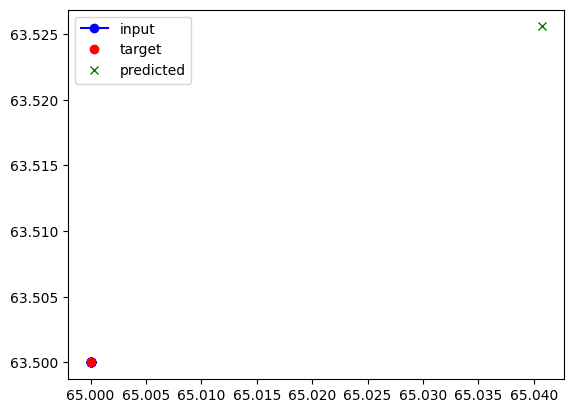

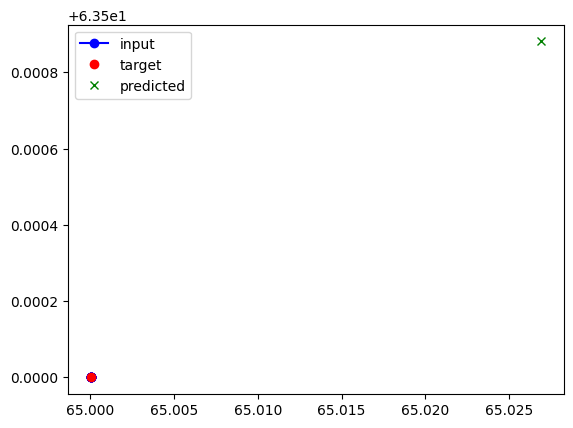

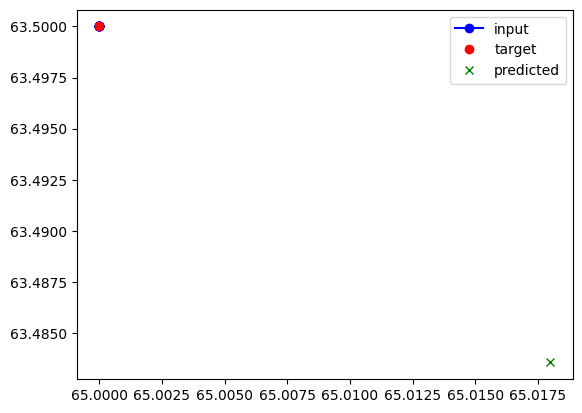

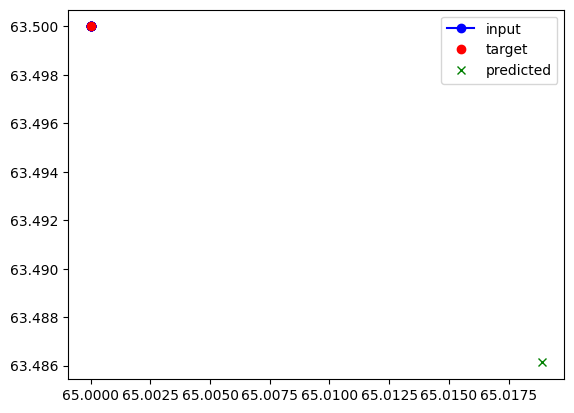

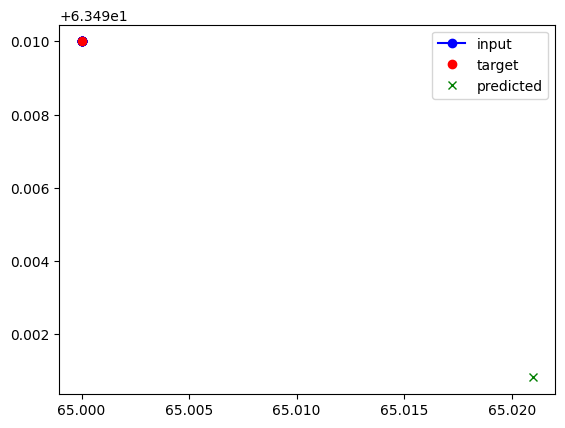

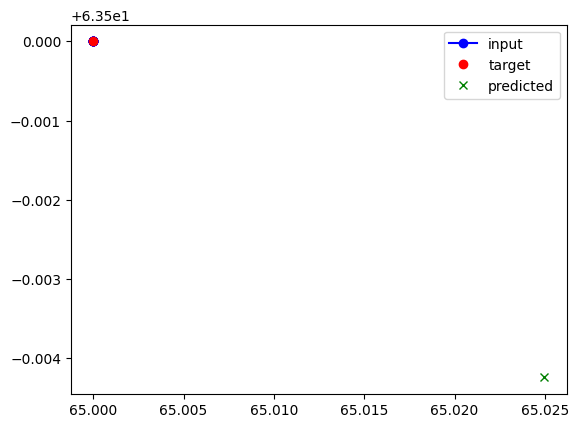

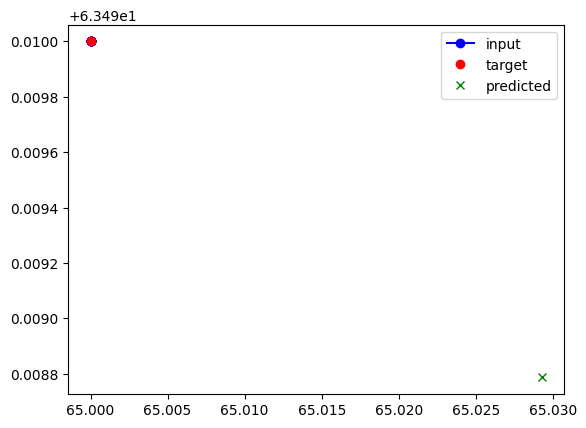

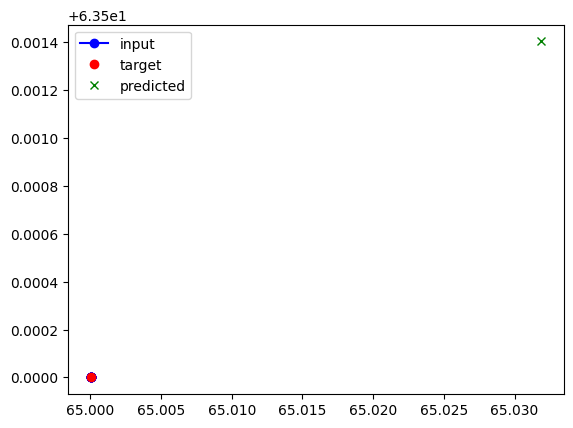

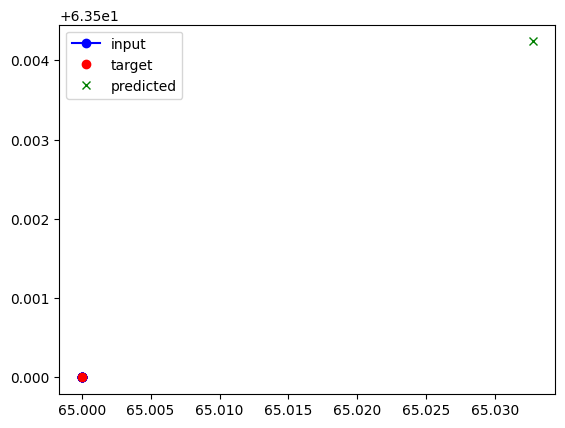

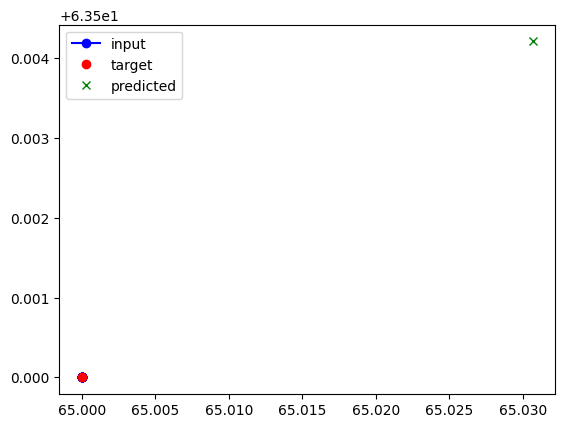

In [7]:
# 테스트 데이터 예측
test_input = input_data[10:30]
test_target = target_data[10:30]
predicted = model.predict(test_input)

# 예측 결과 시각화
for i in range(10):
    plt.plot(test_input[i, :, 0], test_input[i, :, 1], 'bo-', label='input')
    plt.plot(test_target[i, 0], test_target[i, 1], 'ro', label='target')
    plt.plot(predicted[i, 0], predicted[i, 1], 'gx', label='predicted')
    plt.legend()
    plt.show()

In [20]:
test_target = target_data[3220:3680]
print(test_target, "\n----\n", len(test_target))

[[ 65.          72.5         10.        ]
 [ 65.          72.5         11.        ]
 [ 65.          72.5         12.        ]
 ...
 [ 96.00035858  75.68888092 467.        ]
 [ 96.00035858  75.68888092 468.        ]
 [ 96.00035858  75.68888092 469.        ]] 
----
 460


1/1 [==============================] - 0s 14ms/step


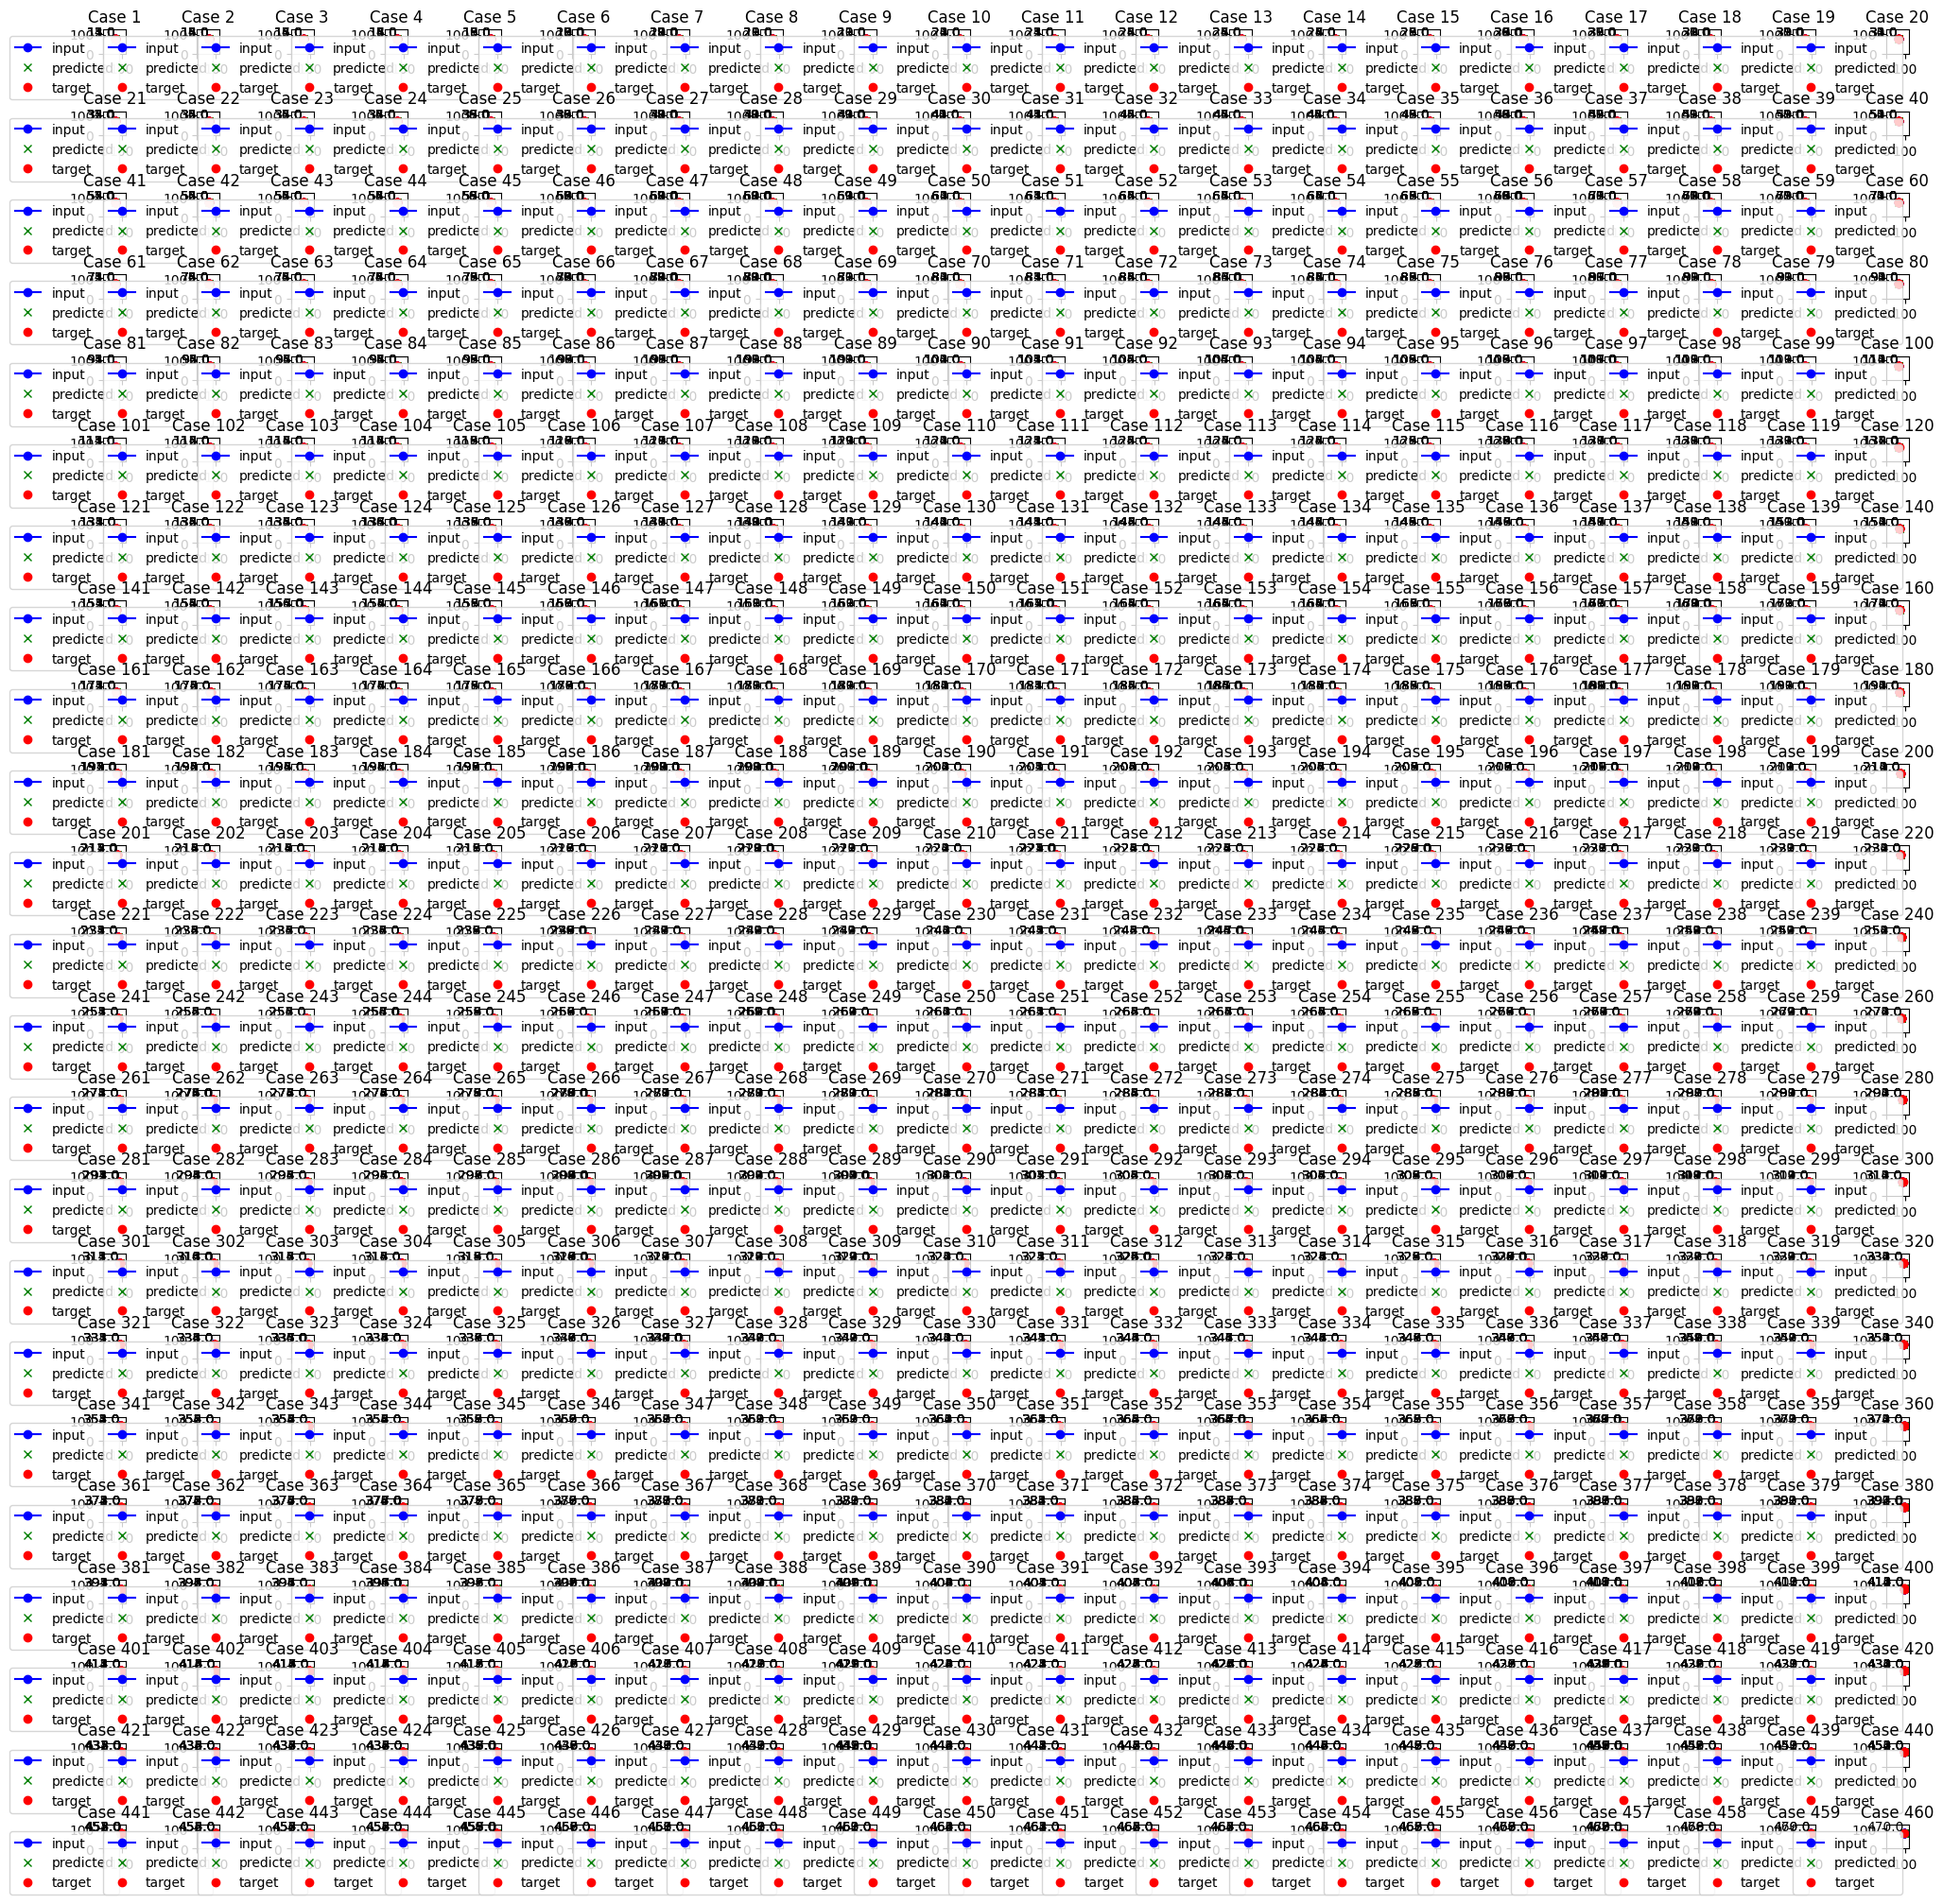

In [22]:
# 주어진 입력 데이터에서 연속적으로 다음 위치 예측 함수
def predict_next_positions(model, input_data, num_steps):
    current_input = input_data.copy()
    predicted_positions = []

    for _ in range(num_steps):
        predicted = model.predict(current_input)
        predicted_positions.append(predicted[0])

        # 처음 4개 좌표와 예측한 좌표로 새로운 입력 데이터 생성
        new_input = np.concatenate((current_input[:, 1:, :], predicted.reshape(1, 1, -1)), axis=1)
        current_input = new_input

    return np.array(predicted_positions)

# 테스트 데이터 예측
test_input = input_data[3220:3680]
test_target = target_data[3220:3680]

# 예측할 위치의 개수
num_steps = 5

fig, axes = plt.subplots(23, 20, figsize=(20, 20))
axes = axes.ravel()

for i in range(460):
    # 테스트 데이터를 사용하여 연속적으로 다음 위치 예측
    predicted_positions = predict_next_positions(model, test_input[i:i+1], num_steps)

    axes[i].plot(test_input[i, :, 0], test_input[i, :, 1], 'bo-', label='input')

    for j, predicted in enumerate(predicted_positions):
        axes[i].plot(predicted[0], predicted[1], 'gx', label='predicted' if j == 0 else '')
        #axes[i].text(predicted[0], predicted[1], '{}'.format(j + 1), fontsize=10, color='black', verticalalignment='bottom', horizontalalignment='right')
        if j == 0:
            # 처음 예측값이면 선을 파랑색 마지막부터 이음 
            continue
        # 이전 예측값과 현재 예측값을 연결하는 선을 그림
        prev_predicted = predicted_positions[j-1]
        axes[i].plot([prev_predicted[0], predicted[0]], [prev_predicted[1], predicted[1]], 'g--')

    for j, target in enumerate(test_target[i:i+num_steps]):
        axes[i].plot(target[0], target[1], 'ro', label='target' if j == 0 else '')
        target_label = target[2] + 1
        axes[i].text(target[0], target[1], target_label, fontsize=10, color='black', verticalalignment='bottom', horizontalalignment='right')
        if j == 0:
            # 처음 예측값이면 선을 파랑색 마지막부터 이음 
            continue
        prev_targeted = test_target[j-1]
        

    axes[i].plot((test_input[i, 9, 0], predicted_positions[0][0]), (test_input[i, 9, 1],predicted_positions[0][1]), '--')
    axes[i].set_xlim([0, 120])
    axes[i].set_ylim([0, 120])
    axes[i].set_title('Case {}'.format(i + 1))
    axes[i].legend()

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 18ms/step


/tmp/ipykernel_541075/2877749217.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(filename) for filename in filenames]


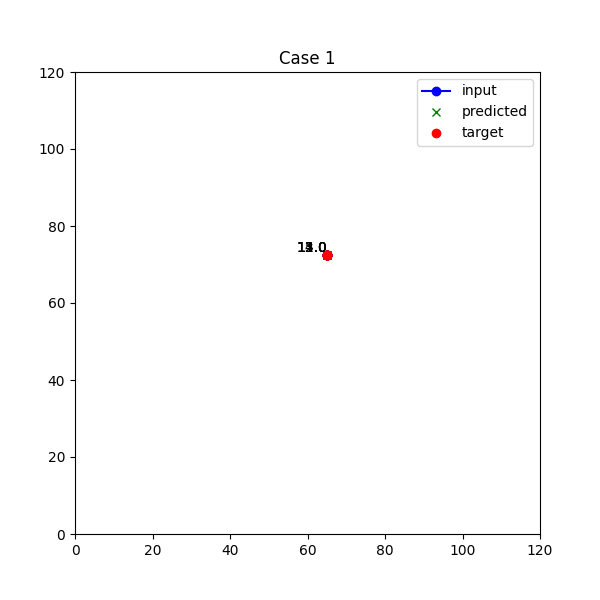

In [23]:
import imageio
from IPython.display import Image

# 이미지를 저장할 디렉토리 생성
import os
if not os.path.exists('images'):
    os.makedirs('images')

# 움짤 생성 함수
def create_gif(filenames, output_file, duration=0.5):
    images = [imageio.imread(filename) for filename in filenames]
    imageio.mimsave(output_file, images, duration=duration)

# 움짤로 만들 그래프 이미지 저장
filenames = []

for i in range(460):
    fig, ax = plt.subplots(figsize=(6, 6))
    predicted_positions = predict_next_positions(model, test_input[i:i+1], num_steps)

    ax.plot(test_input[i, :, 0], test_input[i, :, 1], 'bo-', label='input')

    for j, predicted in enumerate(predicted_positions):
        ax.plot(predicted[0], predicted[1], 'gx', label='predicted' if j == 0 else '')
        if j == 0:
            continue
        prev_predicted = predicted_positions[j-1]
        ax.plot([prev_predicted[0], predicted[0]], [prev_predicted[1], predicted[1]], 'g--')

    for j, target in enumerate(test_target[i:i+num_steps]):
        ax.plot(target[0], target[1], 'ro', label='target' if j == 0 else '')
        target_label = target[2] + 1
        ax.text(target[0], target[1], target_label, fontsize=10, color='black', verticalalignment='bottom', horizontalalignment='right')
        if j == 0:
            continue
        prev_targeted = test_target[j-1]

    ax.plot((test_input[i, 9, 0], predicted_positions[0][0]), (test_input[i, 9, 1],predicted_positions[0][1]), '--')
    ax.set_xlim([0, 120])
    ax.set_ylim([0, 120])
    ax.set_title('Case {}'.format(i + 1))
    ax.legend()

    # 이미지 저장
    filename = f'images/case_{i + 1}.png'
    filenames.append(filename)
    fig.savefig(filename)
    plt.close(fig)

# 움짤 생성
create_gif(filenames, 'output.gif', duration=0.5)

# 움짤 표시
Image(filename="output.gif")
